# Imports

In [5]:
import os

In [6]:
from skimage.segmentation import watershed, felzenszwalb
from skimage.filters import sobel
import pandas as pd
from pathlib import Path
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.filters import rank
from scipy import ndimage as ndi
from skimage.morphology import disk
import sklearn.metrics

# Handling the data

In [7]:
# Load the train labels
# Note the transpose!
data_dir = os.path.join(os.getcwd(), "data/").replace('notebooks/','')
labels_train = pd.read_csv(data_dir  + "Y_train.csv", index_col=0).T

In [8]:
labels_train

,Pixel 0,Pixel 1,Pixel 2,Pixel 3,Pixel 4,Pixel 5,Pixel 6,Pixel 7,Pixel 8,Pixel 9,...,Pixel 262134,Pixel 262135,Pixel 262136,Pixel 262137,Pixel 262138,Pixel 262139,Pixel 262140,Pixel 262141,Pixel 262142,Pixel 262143
0.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Here is a function to load the data
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

In [10]:
# Load the train and test sets
# If you've put the shortcut directly in your drive, this should work out of the box
# Else, edit the path

data_train = load_dataset(data_dir + "X_train")
data_test = load_dataset(data_dir + "X_test")

In [11]:
# The train data is a numpy array of 1000 images of 512*512
print(f"X_train shape: {data_train.shape}")
# The train label is a dataframe of 1000 rows with 262144 (=512x512) columns
print(f"Y_train shape: {labels_train.shape}")

X_train shape: (1000, 512, 512)
Y_train shape: (1000, 262144)


In [12]:
a = labels_train.iloc[0].values.reshape((512,512))
np.nonzero(a)

(array([104, 104, 104, ..., 419, 419, 419]),
 array([295, 296, 297, ..., 289, 290, 291]))

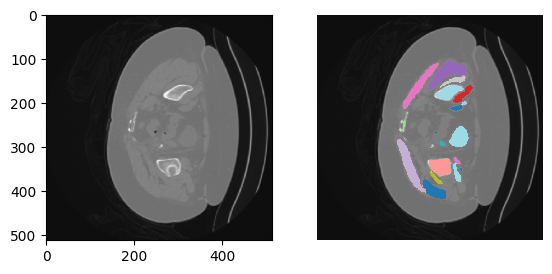

In [13]:
# Let's display some data
# Here is a function to display side by side a slide and a segmented mask
def plot_slice_seg(slice_image, seg):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(slice_image, cmap="gray")
    axes[1].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg.reshape((512,512)) == 0, (seg.reshape((512,512))))
    axes[1].imshow(seg_masked, cmap="tab20")
    plt.axis("off")

# Let's try it on a slide and ites segmentation mask
# Note: we have to reshape the rows of the dataframe into a 512*512 matrix
plot_slice_seg(data_train[0], labels_train.iloc[0].values.reshape((512,512)))

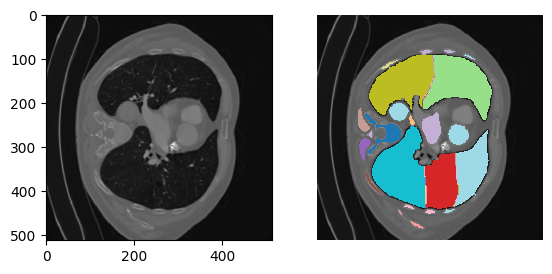

In [14]:
# Let's display some data
# Here is a function to display side by side a slide and a segmented mask
def plot_slice_seg(slice_image, seg):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(slice_image, cmap="gray")
    axes[1].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg.reshape((512,512)) == 0, (seg.reshape((512,512))))
    axes[1].imshow(seg_masked, cmap="tab20")
    plt.axis("off")

# Let's try it on a slide and ites segmentation mask
# Note: we have to reshape the rows of the dataframe into a 512*512 matrix
plot_slice_seg(data_train[2], labels_train.iloc[2].values.reshape((512,512)))

# Let's compute a baseline

In [13]:
# Let's take a very basic watershed baseline
def compute_baseline_one_sample(data_slice):
    edges = sobel(data_slice)
    denoised = rank.median(data_slice, disk(2))
    markers = rank.gradient(denoised, disk(5)) < 20
    markers = ndi.label(markers)[0]
    label_predicted = watershed(edges, markers=markers, compactness=0.0001)
    return label_predicted

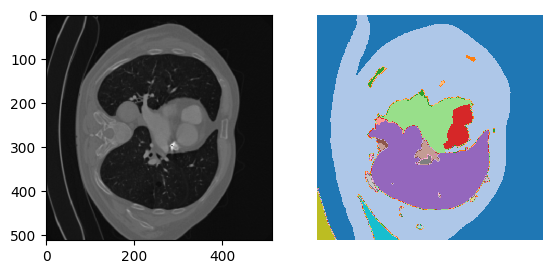

In [14]:
# Let's display the results
# Not too bad!
plot_slice_seg(data_train[2], compute_baseline_one_sample(data_train[2]))

## Let's measure its performances

In [15]:
# Compute the baseline on a whole dataset
def compute_baseline(dataset: np.array):
    labels_predicted_list = []
    for data_index in tqdm(range(len(dataset))):
        data_slice = dataset[data_index]
        label_predicted = compute_baseline_one_sample(data_slice)
        labels_predicted_list.append(label_predicted)
    return pd.DataFrame(np.stack(labels_predicted_list, axis=0).reshape((len(labels_predicted_list), -1)))

In [16]:
# Let's create a validation set first: the 200 first images of the train set
data_val = data_train[:200]
labels_val = labels_train.iloc[:200]

In [17]:
# Compute baseline on a few train data
labels_val_predicted_baseline = compute_baseline(data_val)

100%|█████████████████████████████████████████| 200/200 [00:31<00:00,  6.44it/s]


In [18]:
def rand_index_dataset(y_true_df: pd.DataFrame, y_pred_df: pd.DataFrame) -> float:
    """Compute the individual rand index for each sample in the dataset and then average it"""
    individual_rand_index = []
    for row_index in range(y_true_df.values.shape[0]):
        labels = y_true_df.values[row_index]
        preds = y_pred_df.values[row_index]
        individual_rand_index.append(sklearn.metrics.adjusted_rand_score(labels, preds))

    return np.mean(individual_rand_index)

In [19]:
# Compute the metric on the validation set
rand_index_dataset(labels_val, labels_val_predicted_baseline)
# We get => 0.14 (0.1369409193608601); Not so bad, but room for improvements!
# Let's see if you can do better!

0.1369409193608601